In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!pip -qq install catboost

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sn
sn.set_theme(color_codes=True)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import joblib
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from time import time
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import matplotlib.animation as animation
from IPython.display import HTML
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")


In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/dataa.csv')
print(df.columns)
cdf = df[[ 'RH2M', 'PS', 'T2M_MAX', 'WS10M_RANGE',
       'WS10M_MIN', 'WS10M_MAX', 'WS10M', 'T2M', 'SST','PRECIP']]
cdf.head()

Index(['LAT', 'LON', 'YEAR', 'DOY', 'RH2M', 'PS', 'T2M_MAX', 'WS10M_RANGE',
       'WS10M_MIN', 'WS10M_MAX', 'WS10M', 'T2M', 'SST', 'PRECIP', 'CHIRPS'],
      dtype='object')


,RH2M,PS,T2M_MAX,WS10M_RANGE,WS10M_MIN,WS10M_MAX,WS10M,T2M,SST,PRECIP
0,64.960,84.834,26.934,2.918,0.620,3.540,2.172,21.700,27.5790,4.128
1,62.536,84.954,27.382,4.018,0.876,4.896,2.796,21.750,28.0790,0.836
2,67.602,84.892,26.598,3.082,0.562,3.644,1.952,21.744,28.3800,3.954
3,66.372,84.864,27.334,4.264,0.624,4.890,2.660,21.920,28.0525,5.686
4,57.580,84.876,28.274,5.968,0.456,6.424,3.322,22.360,27.9575,0.300


In [8]:
cdf.shape

(2849, 10)

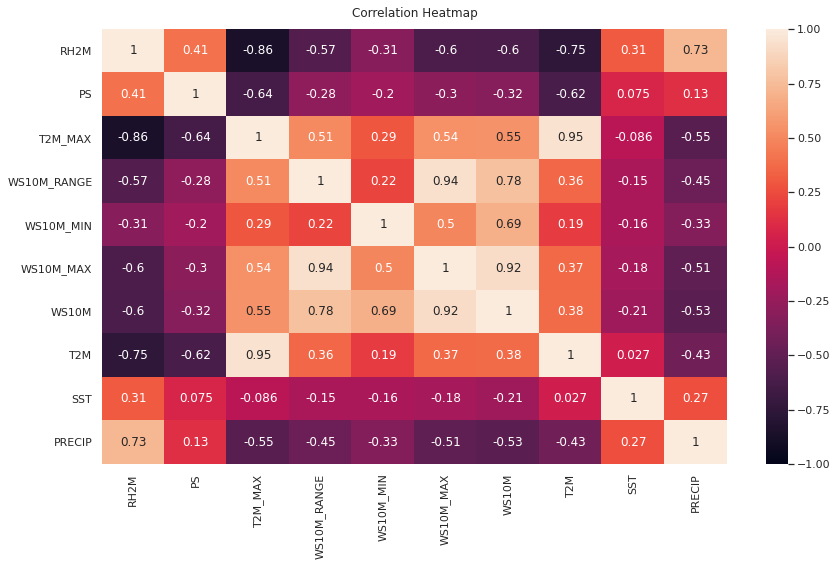

In [9]:
correlation = cdf.corr(method= 'spearman', min_periods=1)

plt.figure(figsize=(14, 8))

heatmap = sn.heatmap(correlation, vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Step Akaike Information Criterion

In [10]:
def forward_selected(cdf, PRECIP):
    remaining = set(cdf.columns)
    remaining.remove(PRECIP)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} ".format(PRECIP,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, cdf).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} ".format(PRECIP,
                                   ' + '.join(selected))
    model = smf.ols(formula, cdf).fit()
 
    return model

def main():
    model = forward_selected(cdf, 'PRECIP')
 
    print(model.model.formula)
    print(model.params)
    print(model.rsquared_adj)
    
 
if __name__ == '__main__':
    main()

PRECIP ~ RH2M + PS + T2M + SST + T2M_MAX 
Intercept    844.055318
RH2M           0.348986
PS           -10.372179
T2M            1.141029
SST            0.456045
T2M_MAX       -0.677496
dtype: float64
0.47174441508796805


## Scikitlearn Models

In [11]:
cdff = cdf[['RH2M','PS','T2M','SST','T2M_MAX','PRECIP']]
cdff.head()

,RH2M,PS,T2M,SST,T2M_MAX,PRECIP
0,64.960,84.834,21.700,27.5790,26.934,4.128
1,62.536,84.954,21.750,28.0790,27.382,0.836
2,67.602,84.892,21.744,28.3800,26.598,3.954
3,66.372,84.864,21.920,28.0525,27.334,5.686
4,57.580,84.876,22.360,27.9575,28.274,0.300


>knn -2.336 (0.126)
>cart -2.895 (0.166)
>svm -2.259 (0.105)


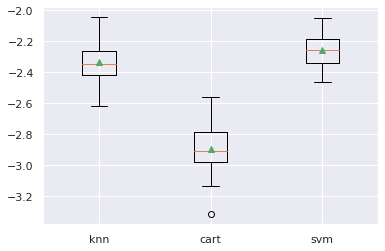

In [12]:
# compare machine learning models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X = cdff.loc[:, cdff.columns != 'PRECIP']
y = cdff.loc[:, 'PRECIP']
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## Multiple Linear regression Model

In [13]:
msk = np.random.rand(len(cdff)) < 0.8
train = cdff[msk]
test = cdff[~msk]

regr = linear_model.LinearRegression()
X = np.asanyarray(train[['RH2M','PS','T2M','SST','T2M_MAX']])
y = np.asanyarray(train[['PRECIP']])
regr.fit (X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

print('############################################################################################')

y_hat= regr.predict(test[['RH2M','PS','T2M','SST','T2M_MAX']])
X = np.asanyarray(test[['RH2M','PS','T2M','SST','T2M_MAX']])
y = np.asanyarray(test[['PRECIP']])
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
r2 = regr.score(X, y)
print('Variance score: %.2f' % r2)

Coefficients:  [[ 0.37002611 -9.89553974  1.09172317  0.45250592 -0.56072647]]
############################################################################################
Residual sum of squares: 11.66
Variance score: 0.46


## Spearman's Rank Correlation

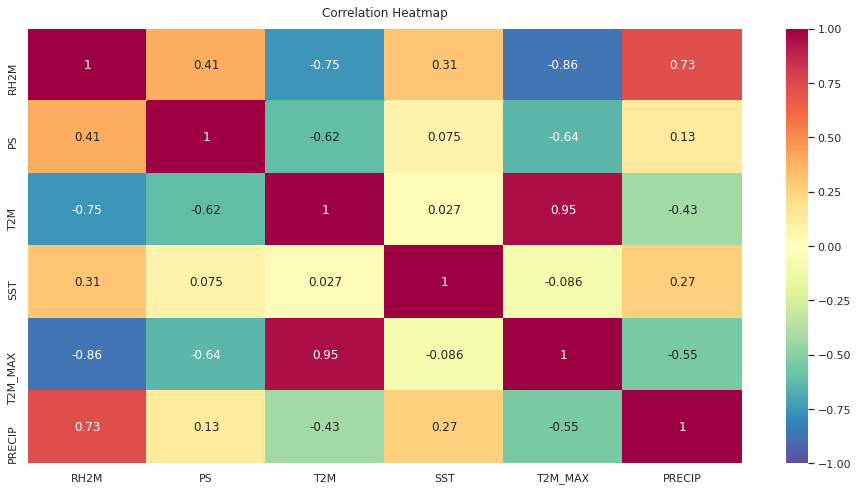

In [17]:
correlation1 = cdff.corr(method = "spearman")

plt.figure(figsize=(16, 8))

heatmap = sn.heatmap(correlation1, vmin=-1, vmax=1, annot=True, cmap ='Spectral_r')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Scatter Plots

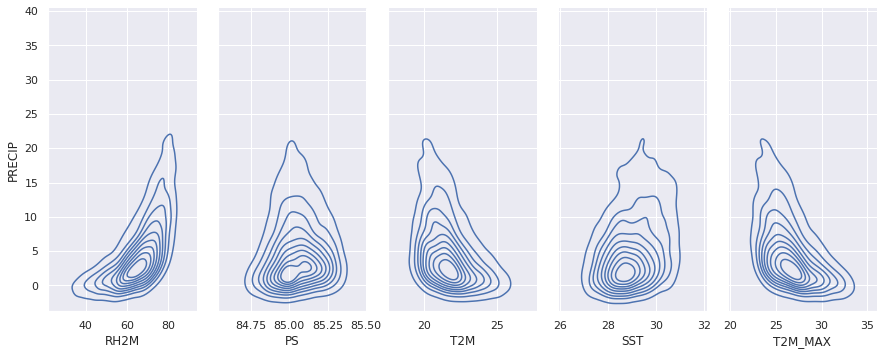

In [13]:
sn.pairplot(cdff, x_vars=['RH2M','PS','T2M','SST','T2M_MAX'], y_vars=["PRECIP"],
             height=5, aspect=.5, kind="kde");

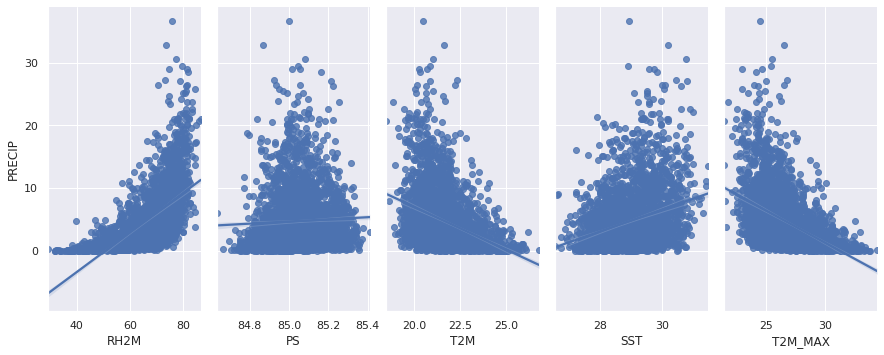

In [14]:
sn.pairplot(cdff, x_vars=['RH2M','PS','T2M','SST','T2M_MAX'], y_vars=["PRECIP"],
             height=5, aspect=.5, kind="reg");

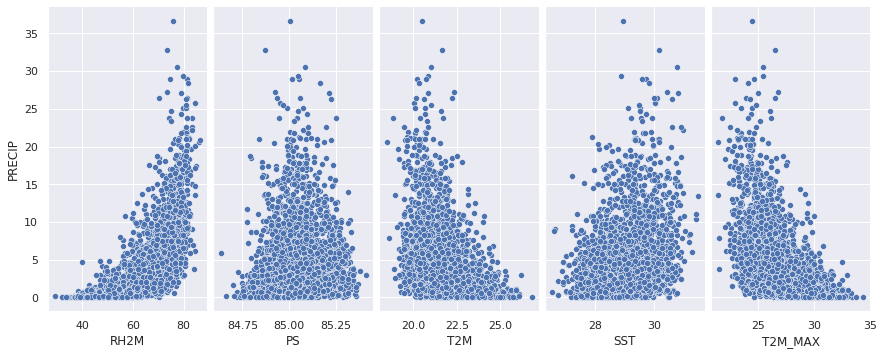

In [15]:
sn.pairplot(cdff, x_vars=['RH2M','PS','T2M','SST','T2M_MAX'], y_vars=["PRECIP"],
             height=5, aspect=.5, diag_kind="hist");

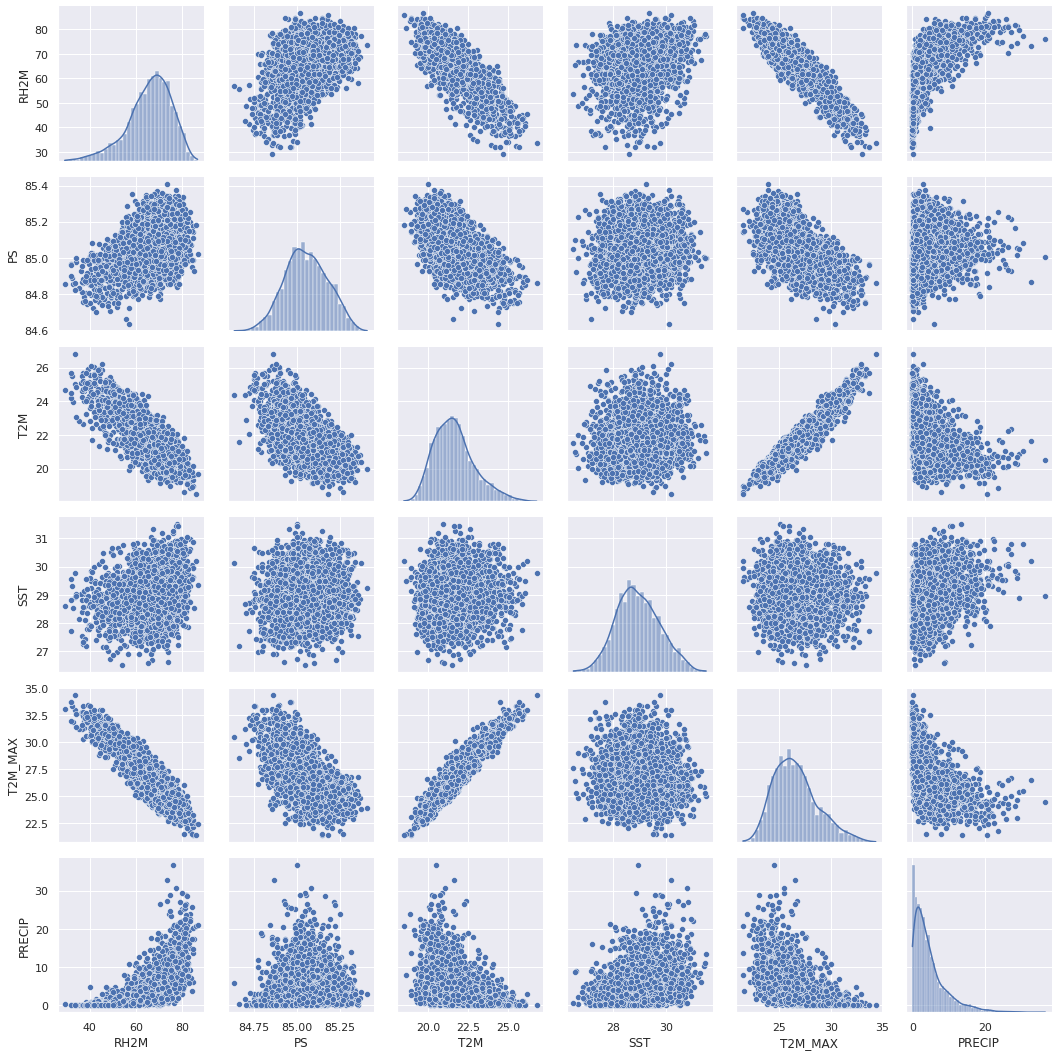

In [16]:
g = sn.PairGrid(cdff)
g.map_diag(sn.histplot,kde=True)
g.map_offdiag(sn.scatterplot)

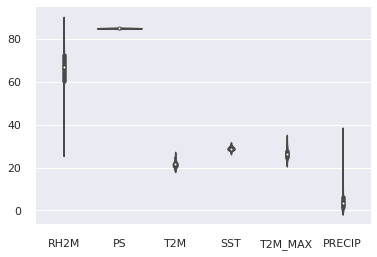

In [17]:
f, ax = plt.subplots()
sn.violinplot(data=cdff)
sn.despine(offset=5, trim=True);

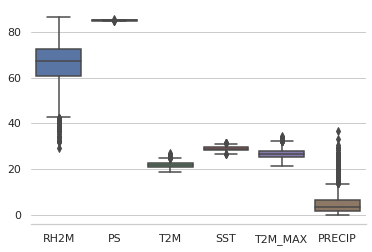

In [18]:
sn.set_style("whitegrid")
sn.boxplot(data=cdff, palette="deep")
sn.despine(left=True)

In [19]:
features = cdff.drop(['PRECIP'], axis=1)
labels = cdff['PRECIP']

X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.5,random_state=42)

In [20]:
for dataset in(y_train,y_val,y_test):
    print(round(len(dataset)/len(labels),2))

0.8
0.1
0.1


In [21]:
X_train.to_csv('train_features.csv', index=False)
X_val.to_csv('val_features.csv', index=False)
X_test.to_csv('test_features.csv', index=False)

y_train.to_csv('train_labels.csv', index=False)
y_val.to_csv('val_labels.csv', index=False)
y_test.to_csv('test_labels.csv', index=False)

In [22]:
tr_features = pd.read_csv('train_features.csv')
tr_labels = pd.read_csv('train_labels.csv')

## Linear Regression Model

In [23]:
print(linear_model.LinearRegression())
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [24]:
mlr = linear_model.LinearRegression()
parameters = {
    'copy_X':['True','False'],
    'fit_intercept': ['True','False'],
    'n_jobs': ['None',[1,3,5,10]]
}
cv = GridSearchCV(mlr,parameters,cv=5)
cv.fit(features,labels.values.ravel())

print_results(cv)

BEST PARAMS: {'copy_X': 'True', 'fit_intercept': 'True', 'n_jobs': 'None'}

0.454 (+/-0.056) for {'copy_X': 'True', 'fit_intercept': 'True', 'n_jobs': 'None'}
0.454 (+/-0.056) for {'copy_X': 'True', 'fit_intercept': 'True', 'n_jobs': [1, 3, 5, 10]}
0.454 (+/-0.056) for {'copy_X': 'True', 'fit_intercept': 'False', 'n_jobs': 'None'}
0.454 (+/-0.056) for {'copy_X': 'True', 'fit_intercept': 'False', 'n_jobs': [1, 3, 5, 10]}
0.454 (+/-0.056) for {'copy_X': 'False', 'fit_intercept': 'True', 'n_jobs': 'None'}
0.454 (+/-0.056) for {'copy_X': 'False', 'fit_intercept': 'True', 'n_jobs': [1, 3, 5, 10]}
0.454 (+/-0.056) for {'copy_X': 'False', 'fit_intercept': 'False', 'n_jobs': 'None'}
0.454 (+/-0.056) for {'copy_X': 'False', 'fit_intercept': 'False', 'n_jobs': [1, 3, 5, 10]}


In [25]:
cv.best_estimator_

LinearRegression(copy_X='True', fit_intercept='True', n_jobs='None',
                 normalize=False)

In [26]:
joblib.dump(cv.best_estimator_,'MLR_model.pkl')

['MLR_model.pkl']

## Multi Layer Perceptron

In [27]:
print(MLPRegressor())
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


In [28]:
mlp = MLPRegressor()
parameters = {
    'hidden_layer_sizes': [(10,),(50,),(100,)],
    'activation': ['relu','tanh','logistic'],
    'learning_rate': ['constant','invscaling','adaptive']
}
cv1 = GridSearchCV(mlp,parameters,cv=5)
cv1.fit(features,labels.values.ravel())

print_results(cv1)

BEST PARAMS: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive'}

0.406 (+/-0.079) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.413 (+/-0.087) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.447 (+/-0.089) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.504 (+/-0.039) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.511 (+/-0.047) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.49 (+/-0.056) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.498 (+/-0.038) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.515 (+/-0.032) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.487 (+/-0.076) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learni

In [29]:
cv1.best_estimator_

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [30]:
joblib.dump(cv1.best_estimator_,'MLP_model.pkl')

['MLP_model.pkl']

## Random Forest Regressor

In [31]:
print(RandomForestRegressor())
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [32]:
rf = RandomForestRegressor()
parameters = {
    'n_estimators': [10,50,200,400],
    'max_depth': [2,4,8,16,None]
}
cv2 = GridSearchCV(rf,parameters,cv=5)
cv2.fit(features,labels.values.ravel())
print_results(cv2)

BEST PARAMS: {'max_depth': 4, 'n_estimators': 50}

0.475 (+/-0.033) for {'max_depth': 2, 'n_estimators': 10}
0.477 (+/-0.016) for {'max_depth': 2, 'n_estimators': 50}
0.476 (+/-0.015) for {'max_depth': 2, 'n_estimators': 200}
0.477 (+/-0.013) for {'max_depth': 2, 'n_estimators': 400}
0.547 (+/-0.026) for {'max_depth': 4, 'n_estimators': 10}
0.552 (+/-0.013) for {'max_depth': 4, 'n_estimators': 50}
0.551 (+/-0.014) for {'max_depth': 4, 'n_estimators': 200}
0.552 (+/-0.014) for {'max_depth': 4, 'n_estimators': 400}
0.519 (+/-0.042) for {'max_depth': 8, 'n_estimators': 10}
0.551 (+/-0.036) for {'max_depth': 8, 'n_estimators': 50}
0.547 (+/-0.03) for {'max_depth': 8, 'n_estimators': 200}
0.549 (+/-0.03) for {'max_depth': 8, 'n_estimators': 400}
0.497 (+/-0.04) for {'max_depth': 16, 'n_estimators': 10}
0.526 (+/-0.048) for {'max_depth': 16, 'n_estimators': 50}
0.533 (+/-0.042) for {'max_depth': 16, 'n_estimators': 200}
0.532 (+/-0.035) for {'max_depth': 16, 'n_estimators': 400}
0.486 (+/-0.

In [33]:
cv2.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [34]:
joblib.dump(cv2.best_estimator_,'RF_model.pkl')

['RF_model.pkl']

## Gradient Boosted Trees

In [35]:
print(GradientBoostingRegressor())
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [36]:
gb = GradientBoostingRegressor()
parameters = {
    'n_estimators': [5,50,200,400],
    'max_depth': [1,3,5,7,9],
    'learning_rate': [0.01,0.1,1]
}
cv3 = GridSearchCV(gb,parameters,cv=5)
cv3.fit(features,labels.values.ravel())

print_results(cv3)

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}

0.017 (+/-0.035) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.214 (+/-0.043) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.425 (+/-0.024) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}
0.487 (+/-0.015) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 400}
0.036 (+/-0.038) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.329 (+/-0.06) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.543 (+/-0.026) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
0.556 (+/-0.022) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
0.042 (+/-0.034) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.355 (+/-0.045) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.546 (+/-0.02) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
0.549 (+/-0.024) for {'learning_ra

In [37]:
cv3.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [38]:
joblib.dump(cv3.best_estimator_,'GB_model.pkl')

['GB_model.pkl']

## LGBM Regressor

In [39]:
print(LGBMRegressor())
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [40]:
LGBM = LGBMRegressor()
parameters = {
    'n_estimators': [50,200,400,1000],
    'max_depth': [1,3,5,7,9],
    'learning_rate': [0.01,0.1,1]
}
cv4 = GridSearchCV(LGBM,parameters,cv=5)
cv4.fit(features,labels.values.ravel())

print_results(cv4)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

0.214 (+/-0.046) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.426 (+/-0.025) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 200}
0.487 (+/-0.015) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 400}
0.527 (+/-0.01) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 1000}
0.33 (+/-0.063) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.538 (+/-0.032) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
0.555 (+/-0.013) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400}
0.557 (+/-0.012) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}
0.351 (+/-0.077) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.546 (+/-0.032) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
0.549 (+/-0.011) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
0.542 (+/-0.02) for {'learni

In [41]:
cv4.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=50, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
joblib.dump(cv4.best_estimator_,'LGBM_model.pkl')

['LGBM_model.pkl']

## HistGradienBoosting Regressor

In [43]:
 print(HistGradientBoostingRegressor())
 def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)


In [44]:
HGBR = HistGradientBoostingRegressor()
parameters = {
    'learning_rate': [0.01,0.1,1],
    'max_depth':['None',1,2,3,4]
}
cv5 = GridSearchCV(HGBR,parameters,cv=5)
cv5.fit(features,labels.values.ravel())

print_results(cv5)

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 3}

nan (+/-nan) for {'learning_rate': 0.01, 'max_depth': 'None'}
nan (+/-nan) for {'learning_rate': 0.01, 'max_depth': 1}
0.419 (+/-0.042) for {'learning_rate': 0.01, 'max_depth': 2}
0.464 (+/-0.056) for {'learning_rate': 0.01, 'max_depth': 3}
0.477 (+/-0.059) for {'learning_rate': 0.01, 'max_depth': 4}
nan (+/-nan) for {'learning_rate': 0.1, 'max_depth': 'None'}
nan (+/-nan) for {'learning_rate': 0.1, 'max_depth': 1}
0.557 (+/-0.011) for {'learning_rate': 0.1, 'max_depth': 2}
0.561 (+/-0.02) for {'learning_rate': 0.1, 'max_depth': 3}
0.55 (+/-0.019) for {'learning_rate': 0.1, 'max_depth': 4}
nan (+/-nan) for {'learning_rate': 1, 'max_depth': 'None'}
nan (+/-nan) for {'learning_rate': 1, 'max_depth': 1}
0.493 (+/-0.062) for {'learning_rate': 1, 'max_depth': 2}
0.402 (+/-0.099) for {'learning_rate': 1, 'max_depth': 3}
0.358 (+/-0.098) for {'learning_rate': 1, 'max_depth': 4}


In [45]:
cv5.best_estimator_

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=255, max_depth=3,
                              max_iter=100, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)

In [46]:
joblib.dump(cv5.best_estimator_,'HGBR_model.pkl')

['HGBR_model.pkl']

## AdaBoost Regressor

In [47]:
print(SVR())
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [50]:
SVr = SVR()
cv6 = GridSearchCV(SVr,parameters,cv=5)
cv6.fit(features,labels.values.ravel())
print_results(cv6)

BEST PARAMS: {'epsilon': 1}

0.432 (+/-0.037) for {'epsilon': 0.01}
0.433 (+/-0.037) for {'epsilon': 0.1}
0.435 (+/-0.038) for {'epsilon': 1}


In [51]:
cv6.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [52]:

joblib.dump(cv5.best_estimator_,'SVr_model.pkl')

['SVr_model.pkl']

In [53]:
val_features = pd.read_csv('val_features.csv')
val_labels = pd.read_csv('val_labels.csv')

te_features = pd.read_csv('test_features.csv')
te_labels = pd.read_csv('test_labels.csv')

In [54]:
models = {}

for mdl in ['MLR', 'MLP', 'RF', 'GB','LGBM','SVr','HGBR']:
    models[mdl] = joblib.load('{}_model.pkl'.format(mdl))

In [55]:
models

{'GB': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.01, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 'HGBR': HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                               loss='least_squares', max_bins=255, max_depth=3,
                               max_iter=100, max_leaf_nodes=31,
                               min_samples_leaf=20, n_iter_no_change=None,
                 

In [62]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    model.fit(X_train, y_train) 
    Model_Score = model.score(X_test, y_test) 
    Prediction = model.predict(X_test)
    x = np.linspace(0, 25, 1000)
    #Zero_pred = model.predict([0., 0., 0., 0., 0.])
    rmse = mean_squared_error(y_test, Prediction)**0.5
    print('                                                                               ')
    plt.figure(figsize=(12,8))
    p = plt.scatter(y_test,Prediction,color = 'r')
    m = plt.plot(x, x + 0, color = 'b')
    plt.xlabel('Actual Values',fontsize=14)
    plt.ylabel('Prediction',fontsize=14)
    plt.title('Model Prediction Plot',fontsize=16)
    plt.show()
    print('                                                                               ')
    print('{} -- Model_Score: {} / rmse: {}/ Latency: {}ms'.format(name,Model_Score,rmse,
                                        round((end - start)*1000, 1),fontsize=14))

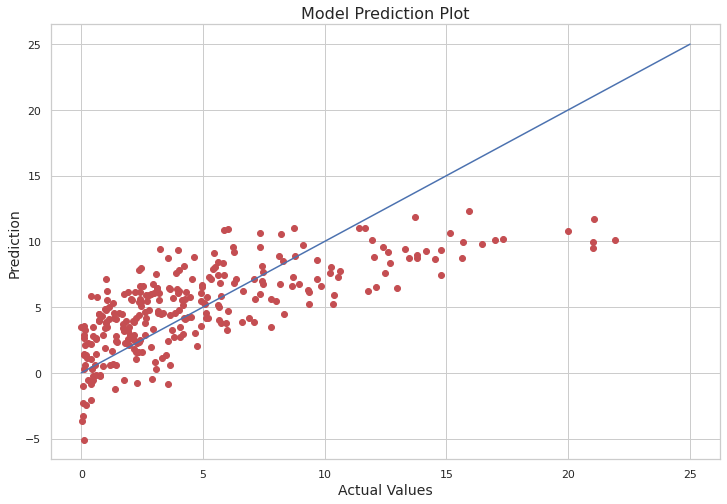

                                                                               
MLR -- Model_Score: 0.5094728279996114 / rmse: 3.1735465117945796/ Latency: 1.0ms
                                                                               


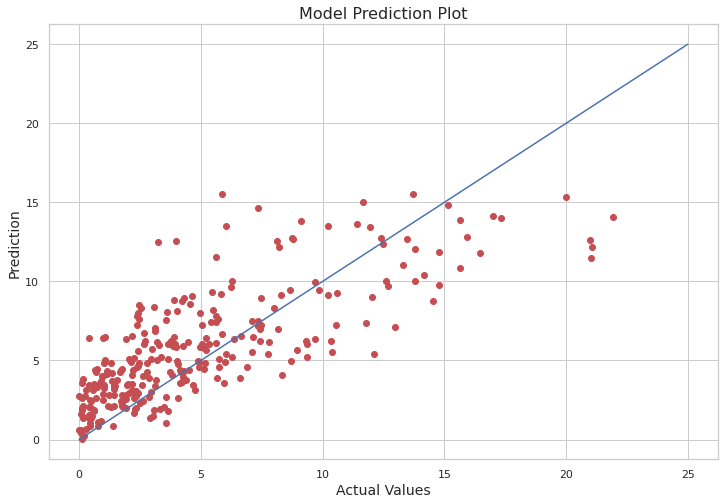

                                                                               
MLP -- Model_Score: 0.5668746019160396 / rmse: 2.982085963771236/ Latency: 7.1ms
                                                                               


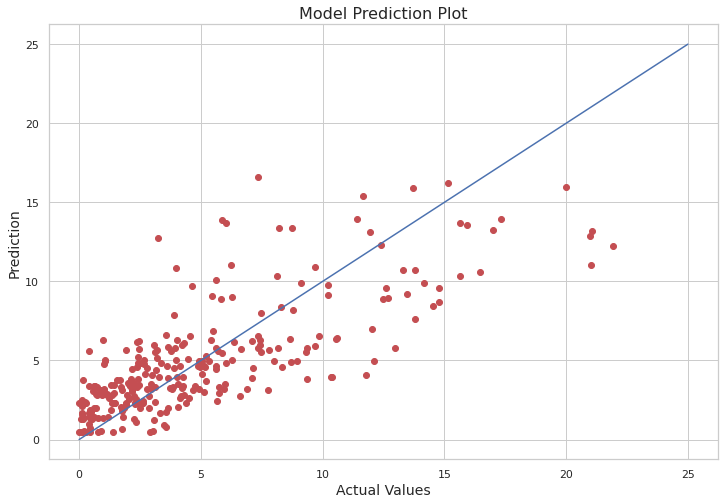

                                                                               
RF -- Model_Score: 0.6000188808692262 / rmse: 2.865715539161609/ Latency: 7.7ms
                                                                               


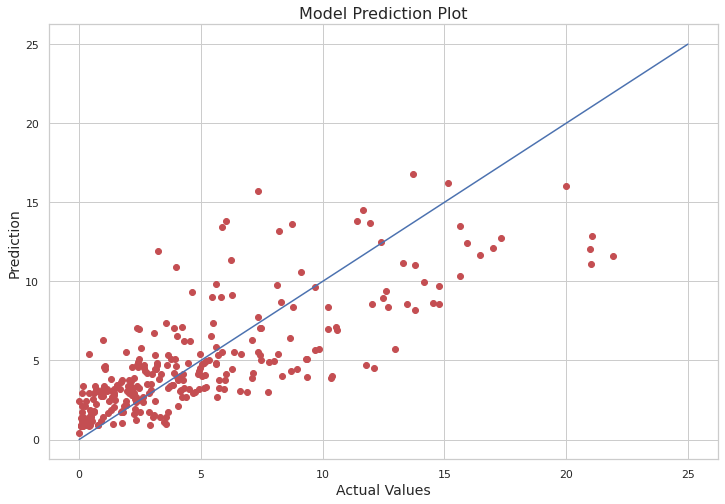

                                                                               
GB -- Model_Score: 0.5960519388456542 / rmse: 2.8798913077208534/ Latency: 3.6ms
                                                                               


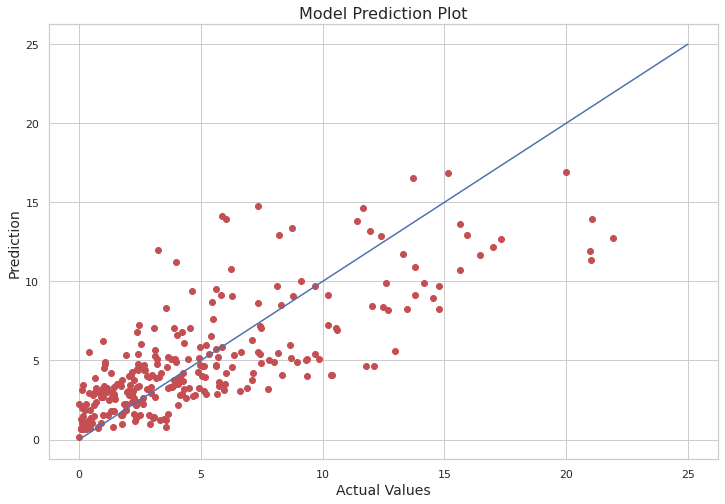

                                                                               
LGBM -- Model_Score: 0.6049087477605453 / rmse: 2.8481446356123037/ Latency: 24.5ms
                                                                               


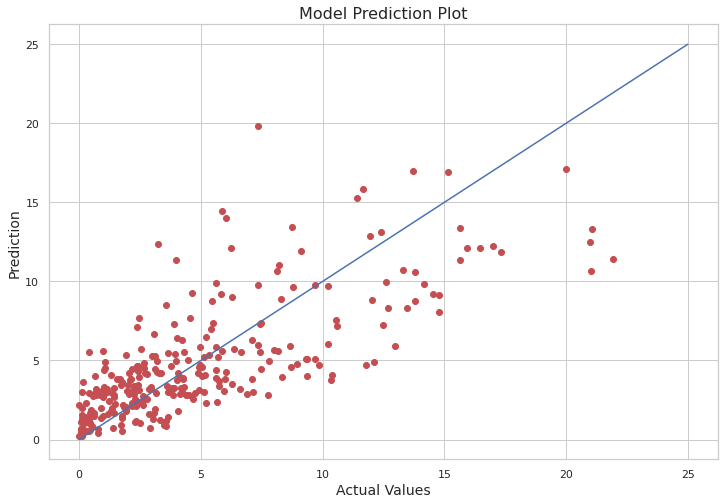

                                                                               
SVr -- Model_Score: 0.5639125134225662 / rmse: 2.992265638870503/ Latency: 21.5ms
                                                                               


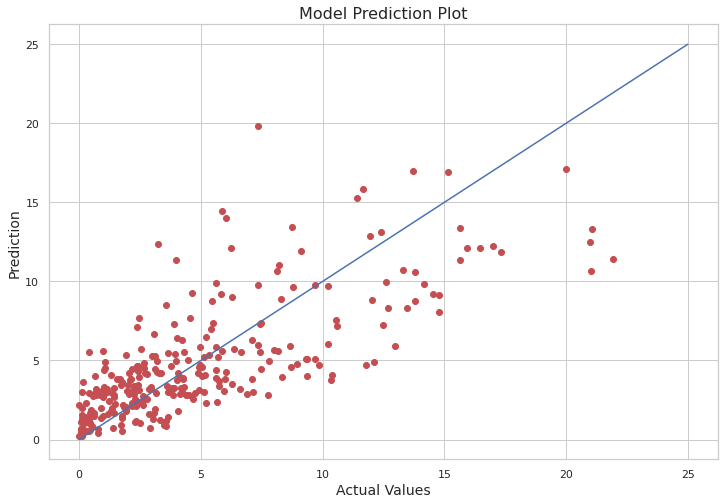

                                                                               
HGBR -- Model_Score: 0.5639125134225662 / rmse: 2.992265638870503/ Latency: 19.6ms


In [63]:
for name, mdl in models.items():
    evaluate_model(name, mdl, X_test, y_test)

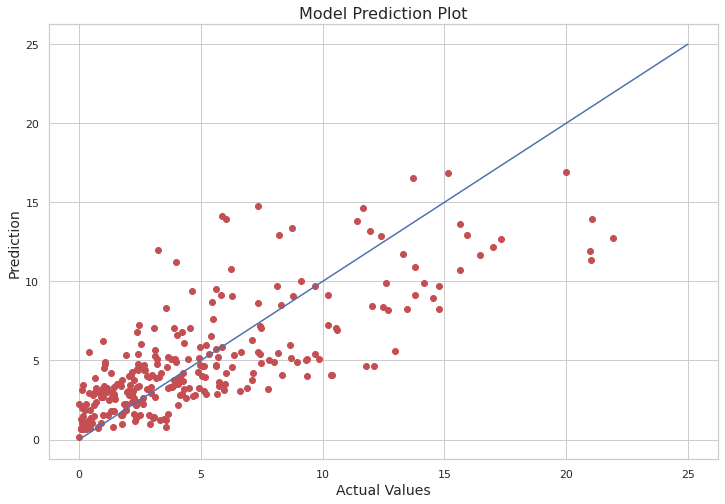

                                                                               
LGBM Regressor -- Model_Score: 0.6049087477605453 / rmse: 2.8481446356123037/ Latency: 8.4ms


In [64]:
evaluate_model('LGBM Regressor', models['LGBM'], X_test,y_test)

## Plotting Results

In [21]:
cdff1 = cdff.copy()
cdff1.head()

,RH2M,PS,T2M,SST,T2M_MAX,PRECIP
0,64.960,84.834,21.700,27.5790,26.934,4.128
1,62.536,84.954,21.750,28.0790,27.382,0.836
2,67.602,84.892,21.744,28.3800,26.598,3.954
3,66.372,84.864,21.920,28.0525,27.334,5.686
4,57.580,84.876,22.360,27.9575,28.274,0.300


In [22]:
cdff1.columns

Index(['RH2M', 'PS', 'T2M', 'SST', 'T2M_MAX', 'PRECIP'], dtype='object')

In [23]:
cdff2 = cdff1.drop('PRECIP',axis = 1)


In [24]:
cdff3 = scale(cdff2)

In [25]:
cols = cdff.columns.tolist()
cols.remove('PRECIP')
cdff3 = pd.DataFrame(cdff3, columns=cols, index=df.index)
cdff3 = pd.concat([cdff3, cdff['PRECIP']], axis=1)
df1 = cdff3.copy()
df1.head()

,RH2M,PS,T2M,SST,T2M_MAX,PRECIP
0,-0.102416,-1.788370,0.039613,-1.722925,0.163173,4.128
1,-0.361942,-0.817110,0.079118,-1.098735,0.372637,0.836
2,0.180450,-1.318928,0.074377,-0.722972,0.006076,3.954
3,0.048760,-1.545555,0.213435,-1.131817,0.350194,5.686
4,-0.892557,-1.448429,0.561081,-1.250413,0.789694,0.300


In [26]:
X = cdff.loc[:, df1.columns != 'PRECIP']
y = cdff.loc[:, 'PRECIP']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [77]:
model1 = Sequential()
model1.add(Dense(5, activation= 'relu',kernel_initializer='normal', input_dim=X_train.shape[1]))
model1.add(Dense(3,activation='relu', kernel_initializer='normal'))
model1.add(Dense(1,kernel_initializer='normal'))
print(model1.summary())

model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model1.fit(X_train , y_train, verbose=1, epochs =200 , validation_data =(X_test,y_test))

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_80 (Dense)             (None, 3)                 18        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 4         
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
72/72 [==============================] - 1s 5ms/step - loss: 44.2429 - mse: 44.2429 - val_loss: 43.1842 - val_mse: 43.1842
Epoch 2/200
72/72 [==============================] - 0s 2ms/step - loss: 39.8550 - mse: 39.8550 - val_loss: 26.6157 - val_mse: 26.6157
Epoch 3/200
72/72 [==============================] - 0s 2ms/step - loss: 25.8097 - mse: 25.8097 - val_loss: 20.5

In [78]:
prediction_test1 = model1.predict(X_test)
print('The maximum pentad precipitation average is : ', max(prediction_test1))
print(len(prediction_test1))

The maximum pentad precipitation average is :  [14.106122]
570


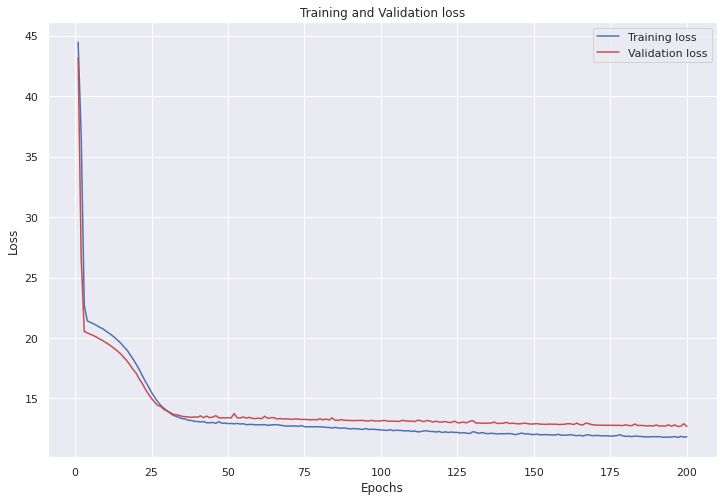

In [79]:
loss = history.history['loss']
val_loss = history.history ['val_loss']
epochs = range(1,len(loss)+1)
plt.figure(figsize=(12,8))
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [80]:
train_pred = model1.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = model1.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE: {:0.2f}".format(train_rmse))
print("Test RMSE: {:0.2f}".format(test_rmse))

Train RMSE: 3.43
Test RMSE: 3.56


## Predictions

In [77]:
print(X_test)

        RH2M      PS     T2M      SST  T2M_MAX
1300  55.530  85.062  23.200  27.8170   28.704
2792  77.010  84.992  21.252  30.0425   25.158
217   55.798  84.664  21.550  27.1925   28.566
984   72.148  85.100  20.752  27.9045   24.622
715   72.768  85.022  20.622  28.5195   24.830
...      ...     ...     ...      ...      ...
2781  81.904  85.164  20.346  29.8370   24.106
51    70.490  85.052  20.754  27.9655   24.632
2743  70.326  85.190  20.474  28.7425   24.246
563   68.758  85.078  20.866  28.0365   25.184
921   70.324  85.106  20.624  28.4965   24.972

[570 rows x 5 columns]


In [78]:
ss = pd.read_csv('/content/gdrive/MyDrive/pred.csv')
print(ss.shape)
ss.head()

(570, 2)


,ID,PRECIP
0,ID_AAcismbB,0
1,ID_AAeBMsji,0
2,ID_AAjFMjzy,0
3,ID_AAmMOEEC,0
4,ID_ABguzDxp,0


In [79]:
ss['PRECIP'] = model1.predict(X_test) 
ss.head(20)

,ID,PRECIP
0,ID_AAcismbB,1.078578
1,ID_AAeBMsji,9.085335
2,ID_AAjFMjzy,1.078578
3,ID_AAmMOEEC,6.860991
4,ID_ABguzDxp,7.123953
5,ID_ABomWihE,11.296331
6,ID_ACDBDjVC,1.078578
7,ID_AEnEBaEk,1.078578
8,ID_AFDiXCWE,6.147050
9,ID_AFFdlZrY,1.078578


In [80]:
Actual_values = y_test[0:20]
Actual_values

1300     1.452
2792    18.918
217      0.224
984      5.488
715      9.984
2769    18.806
2039     1.370
297      0.074
1483    13.734
56       5.258
1389     2.214
553      5.020
1386     2.116
690      8.412
1702     0.246
1413     2.874
106      1.714
916      4.014
1456     0.708
2785     1.922
Name: PRECIP, dtype: float64

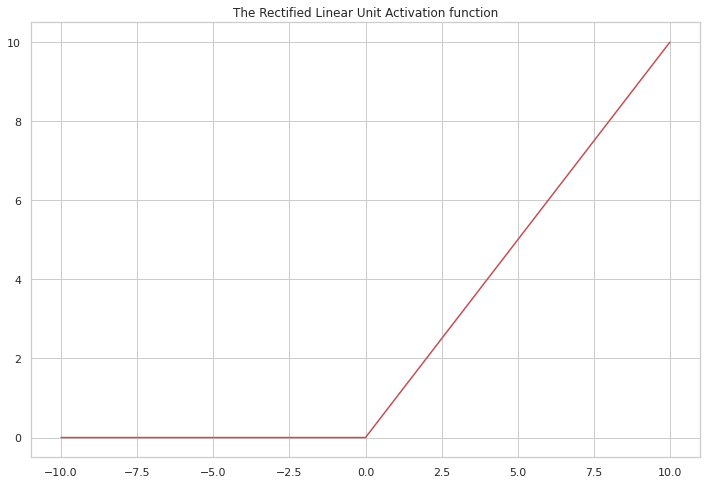

In [81]:
# plot inputs and outputs
from matplotlib import pyplot

# rectified linear function
def rectified(x):
	return max(0.0, x)

# define a series of inputs
series_in = [x for x in range(-10, 11)]
# calculate outputs for our inputs
series_out = [rectified(x) for x in series_in]
# line plot of raw inputs to rectified outputs
plt.figure(figsize=(12,8))
pyplot.plot(series_in, series_out,'r')
plt.title('The Rectified Linear Unit Activation function')
pyplot.show()

## Stacking Regression

>knn -2.323 (0.327)
>cart -2.999 (0.397)
>svm -2.381 (0.368)
>stacking -2.306 (0.276)


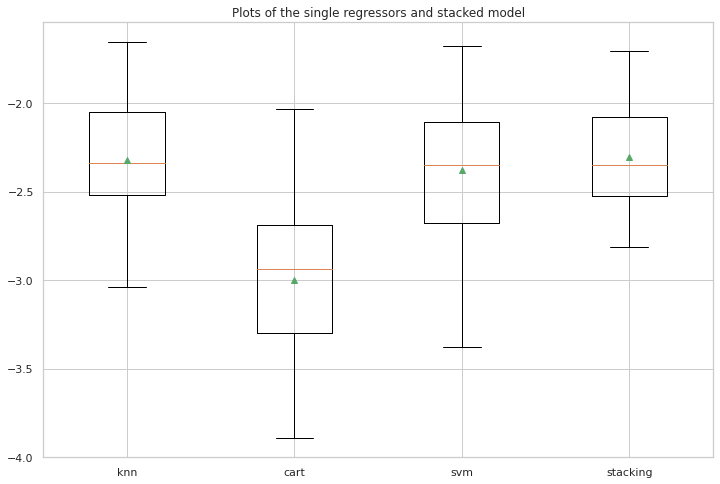

In [82]:
# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot


# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('knn', KNeighborsRegressor()))
  #level0.append(('ann', MLPRegressor()))
	level0.append(('cart', DecisionTreeRegressor()))
	level0.append(('svm', SVR()))
	# define meta learner model
	level1 = LinearRegression()
	# define the stacking ensemble
	model2 = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model2

# get a list of models to evaluate
def get_models():
	models = dict()
	models['knn'] = KNeighborsRegressor()
  #models['mlp'] = MLPRegressor()
	models['cart'] = DecisionTreeRegressor()
	models['svm'] = SVR()
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model2, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
	scores = cross_val_score(model2, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
X = cdff.loc[:, cdff.columns != 'PRECIP']
y = cdff.loc[:, 'PRECIP']
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model2 in models.items():
	scores = evaluate_model(model2, X_test, y_test)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.figure(figsize=(12,8))
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Plots of the single regressors and stacked model")
plt.show()